In [1]:
import pandas as pd
import os
import librosa
import librosa.display
import soundfile as sf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from pydub import AudioSegment
from sklearn.neural_network import MLPClassifier
import pickle
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import codecs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import IPython.display as ipd
from sklearn.svm import SVC
import pickle
from sklearn.ensemble import VotingClassifier


## DATA EXPLORATION

We load whole data file and plot it to see what we have. First three minutes we have a fault engine and the last time we have a good engine.

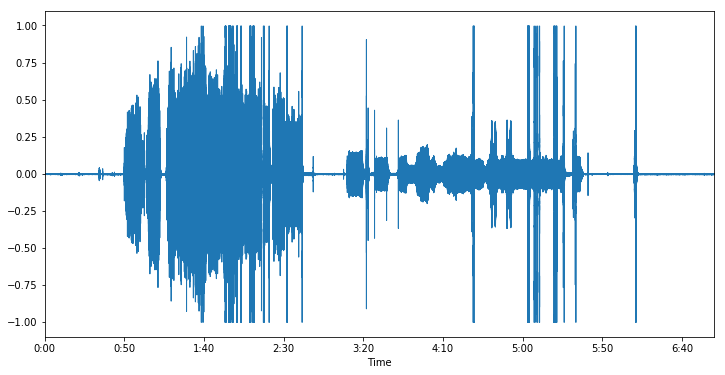

In [97]:
sound_data, sound_sr = librosa.load('engines.wav')
plt.figure(figsize=(12,6))
librosa.display.waveplot(sound_data, sr=sound_sr)
plt.show()

Create helper function to cut our audio file to small parts. Will use AudioSegment
Py library. 
0-47 - silence
48-2.48 - fault engine sound
3.08 - 5.36 - good engine sound
So we create three smaller files with those sound. 
silence.wav, faultEngine.wav,goodEngine.wav

In [98]:
def sound_cutter(start,finish,inputfiliname,outputfilename):
    start = start * 1000 #in milliseconds 1000 = second
    finish = finish *1000
    newAudio = AudioSegment.from_wav(inputfiliname)
    newAudio = newAudio[start:finish]
    return newAudio.export(outputfilename, format='wav')

In [ ]:
# sound_cutter(0,47,'engines.wav','silence.wav')
# sound_cutter(48,168,'engines.wav','faultEngine.wav')
# sound_cutter(188,336,'engines.wav','goodEngine.wav')
#sound_cutter(337,420,'engines.wav','silence2.wav')

 Now we have a three files goodEngine, faultEngine, silence. Then we plot all these files.

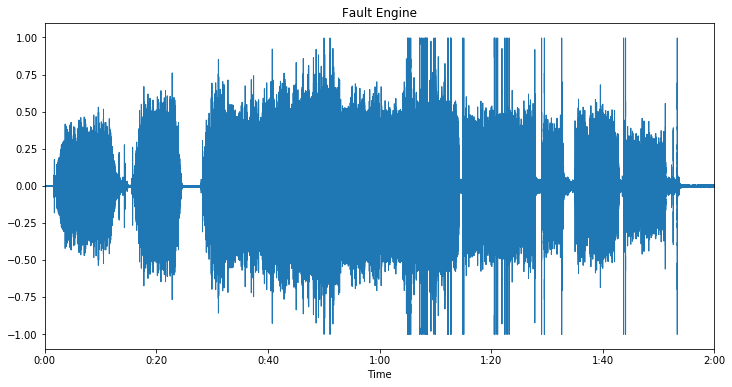

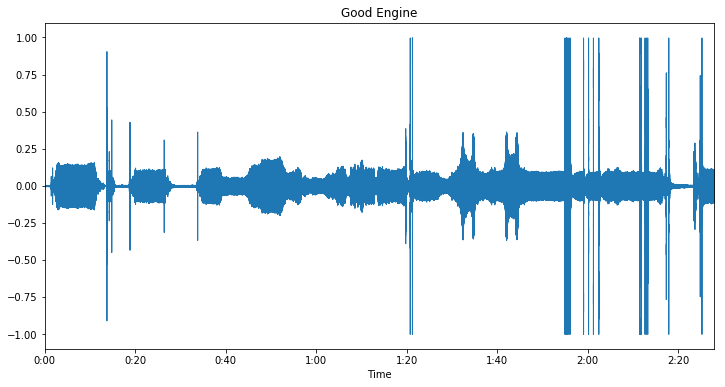

In [101]:
sound_data_faulf, sound_sr_fault = librosa.load('faultEngine.wav')
plt.figure(figsize=(12,6))
librosa.display.waveplot(sound_data_faulf, sr=sound_sr_fault)
plt.title('Fault Engine')
plt.show()
sound_data_good, sound_sr_good = librosa.load('goodEngine.wav')
plt.figure(figsize=(12,6))
librosa.display.waveplot(sound_data_good, sr=sound_sr_good)
plt.title('Good Engine')
plt.show()

Find and plots spectral centroids of the sound samples.

Spectral Centroid Shape is (5168,)
mfccs shape: (20, 5168)
Mean mfccs of fault engie : -5.475989771010388


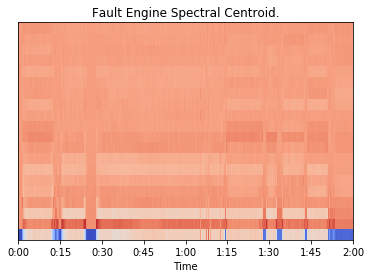

Spectral Centroid Shape is (6374,)
mfccs shape: (20, 6374)
Mean mfccs of fault engie : -7.443754108988754


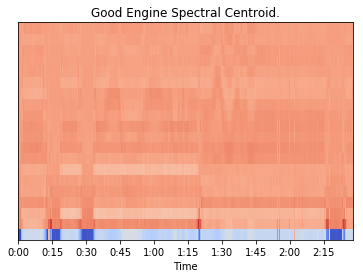

In [105]:
sound_data, sound_sr = librosa.load('faultEngine.wav')
spectral_centroids = librosa.feature.spectral_centroid(sound_data, sr=sound_sr)[0]
print("Spectral Centroid Shape is {}".format(spectral_centroids.shape))
mfccs = librosa.feature.mfcc(sound_data, sr=sound_sr)
print("mfccs shape: {}".format(mfccs.shape))
mean_mfccs = [np.mean(feature) for feature in mfccs]
print("Mean mfccs of fault engie : {}".format(np.mean(mean_mfccs)))
librosa.display.specshow(mfccs, sr=sound_sr, x_axis='time')
plt.title('Fault Engine Spectral Centroid.')
plt.show()

sound_data, sound_sr = librosa.load('goodEngine.wav')
spectral_centroids = librosa.feature.spectral_centroid(sound_data, sr=sound_sr)[0]
print("Spectral Centroid Shape is {}".format(spectral_centroids.shape))
mfccs = librosa.feature.mfcc(sound_data, sr=sound_sr)
print("mfccs shape: {}".format(mfccs.shape))
mean_mfccs = [np.mean(feature) for feature in mfccs]
print("Mean mfccs of fault engie : {}".format(np.mean(mean_mfccs)))
librosa.display.specshow(mfccs, sr=sound_sr, x_axis='time')
plt.title('Good Engine Spectral Centroid.')
plt.show()

Then we split our big sound file to small shunks for the ML model training. Size 4 seconds.

In [ ]:
def sound_cutter2(size,inputfiliname,outputfilename):
    file_len = len(sf.SoundFile(inputfiliname)) // (sf.SoundFile(inputfiliname)).samplerate
    count = file_len // size
    start = 0
    for i in range(0,int(count)):
        finish = start + size
        newAudio = AudioSegment.from_wav(inputfiliname)
        newAudio = newAudio[start*1000:finish*1000]
        newAudio.export(outputfilename + "{}".format(i)+".wav", format='wav')
        start += 1

In [ ]:
#sound_cutter2(4,'faultEngine.wav','bad')
#sound_cutter2(4,'goodEngine.wav','good')
# sound_cutter2(4,'silence.wav','other2')

## MACHINE LEARNING PART

Create .csv labels file and load labels. Use function get_labels with .csv filename as parameter.

In [2]:
def get_labels(filename):
    df = pd.read_csv(filename)
    return df['target'].values


For the sample loading use laod_files function. As output we will have Numpy array of the centroids of the audio file.

In [3]:
def load_audio_files3(filename):
    samples = []
    res,sr = sf.read(filename, always_2d=True)
    samples.append([np.mean(feature) for feature in librosa.feature.mfcc(res.flatten('F')[:res.shape[0]])])
    return np.array(samples) 

Load our labels and samples as X and Y, then split it

In [4]:
def load_files(file):
    return file.flatten('F')[:file.shape[0]]
def mean_mfcc(file):
    return [np.mean(feature) for feature in librosa.feature.mfcc(file)]
def load_audio_files():
    path = "./chunks/"
    path_file_names = os.listdir(path)
    samples = []
    for file_names in path_file_names:
        if file_names != '.DS_Store':
            res,sr = sf.read(path+file_names, always_2d=True)
            res = load_files(res)
            samples.append(mean_mfcc(res))
    return np.array(samples) 

In [5]:
X = load_audio_files()
Y = get_labels('labels.csv')
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.25)

Observe our samples shape, labels

In [6]:
print(f'Shape    :    {X_train.shape}')
print(f'Observation:     \n{X_train[0]}')
print(f'Labels     : {y_train[:5]}')

Shape    :    (69, 20)
Observation:     
[-290.98346096   42.13083377  -59.5333236     2.80365336   16.2752811
    4.45540162  -50.89958374   -2.33683586   26.34207316    7.24441821
   13.12469284    8.91077907   30.11832945   36.86320439    0.67866943
   -0.51962139    2.10216294   -5.82745039    1.23422538   15.28961294]
Labels     : [1 1 2 2 0]


Look at PCA components of our data.

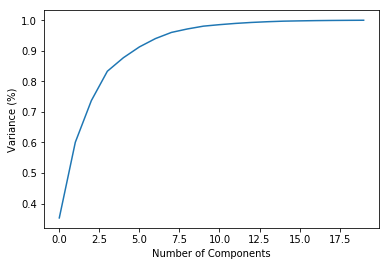

In [7]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
pca = PCA().fit(X_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.show()

We can use PCA scaled data or sceld data. Explored both of that types, but no performance boosting.

Choosen KNN algorithm for the model learning with the grid search, because we have multi class slassifying problem type.I explore several algorithms and KNN gives me best result after many model training attempts.

In [8]:
grid_params = {
    'n_neighbors': [2,3,4, 5 ],
    'weights': ['uniform', 'distance'],
    'algorithm':['ball_tree','kd_tree','brute'],
    'metric': ['euclidean', 'manhattan']
}
modelKN = GridSearchCV(KNeighborsClassifier(), grid_params, cv=2, n_jobs=-1)
modelKN.fit(X_train, y_train)
print(f'Model Score: {modelKN.score(X_test, y_test)}')
y_predict = modelKN.predict(X_test)
print(f'   Confusion Matrix: \n{confusion_matrix(y_predict, y_test)}')

Model Score: 0.5833333333333334
   Confusion Matrix: 
[[3 1 1]
 [2 6 3]
 [2 1 5]]


/Users/vlad3d/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


After we have model with good score, we save it for the future. Also we use model loader for the model load later.

In [9]:
def file_writer(work_model):
     with open('KNN_model_078.pkl','wb') as f:
                pickle.dump(work_model,f)
                
def model_loader(filename):
    with open(filename,'rb') as f:
        new_model = pickle.load(f)
    return new_model

For the predict audio sample we use fault_predictor function. It splits audio file to a chunks and insert this audio chunk in our trained model. As output we have a list of interwals with the model label and probability of that label.

In [10]:
def fault_predictor(size,inputfiliname,model):
    # This string was for the normalizing data testing. No boost.
    #filled_scaller_array = normalizer(size,inputfiliname)
    file_len = len(sf.SoundFile(inputfiliname)) // (sf.SoundFile(inputfiliname)).samplerate
    count = file_len // size
    list_interval = []
    start = 0
    for i in range(0,int(count)):
        finish = start + size
        newAudio = AudioSegment.from_wav(inputfiliname)
        newAudio = newAudio[start*1000:finish*1000]
        filename = 'tempch.wav'
        newAudio.export(filename, format='wav')
        audio_file_array = load_audio_files3(filename)
        #normalized_array = filled_scaller_array.transform(audio_file_array)  
        predict_label = model.predict(audio_file_array)
        predict_proba = model.predict_proba(audio_file_array)
        max_predict = round(max(predict_proba[0]),2)
        if predict_label == 0:
            list_interval.append(str(start)+":"
                                 +str((finish))+ ":"+'Fault - '+ str(max_predict)+ str('%')) 
        elif predict_label == 1:
            list_interval.append(str((start))+":"
                                 +str((finish))+":"+'Good - ' + str(max_predict)+ str('%')) 
        elif predict_label == 2:
            list_interval.append(str((start))+":"
                                 +str((finish))+":"+'Noise -' + str(max_predict)+ str('%'))    
        start += size
    return list_interval 
#'KNN_model_789.pkl - best one till now - good for noise
#'KNN_model_078.pkl' - also good
#'SVM_model_083.pkl'

Test our function. As bigger the audio sample then better the prediction.

In [11]:
new_model = model_loader('KNN_model_789.pkl')
testList = fault_predictor(60,'engines.wav',new_model)
print(testList)

['0:60:Noise -0.33%', '60:120:Fault - 0.67%', '120:180:Good - 0.67%', '180:240:Noise -0.33%', '240:300:Good - 0.33%', '300:360:Noise -0.33%', '360:420:Noise -0.33%']


To write a labels for the Audacity we create this function.As input is uses interwal list with the labels, time interwals and labels probability

In [12]:
def label_writer(interwal_list,outputfileaname):
    output_filename = outputfileaname + 'LABELS.txt'
    output = codecs.open(output_filename, 'w', 'utf-8')
    
    for data in interwal_list:
        temp_array = data.split(":")
        start_time = float(temp_array[0])
        finish_time = float(temp_array[1])
        label = temp_array[2]
        output.write( "%.6f\t%.6f\t%s\n" % (start_time,
                                            finish_time,label ) )
    output.close()   

In [13]:
label_writer(testList,'-testLabels1204')

## CONCLUSION

I have done many training of my model and best performance was given my KNN and SVM model.For that project was used only SCIKIT learn models. Best models gives me 0.75-0.83 accuracy on the test and training set. In real sound file when I use fault_predictor function - models gives me much worst resutls on the small chunks 5-15 seconds and better result on the chunks 30-60 seconds.

#### EXPLORING PART. WAT WAS DONE WITHOUT GOOD MODEL PERFORMANCE.

Was tryed PCA, 5-7 MFCC component contain much of the variance. It was promissing but not more then 0.65 accuracy score of any models using that PCA scaled data.

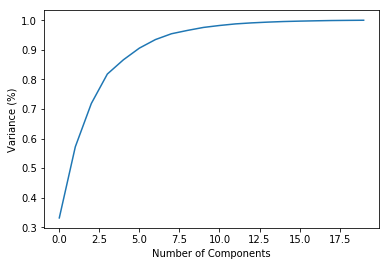

Percent variance explianed by 2 components 98.08%


In [123]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
pca = PCA().fit(X_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.show()
n_comp = 2
new_pca = PCA(n_components=n_comp, whiten=True)
X_train_scaledPCA = new_pca.fit_transform(X_train)
X_test_scaledPCA = new_pca.transform(X_test)
print ("Percent variance explianed by {} components {:0.2f}%".format(n_comp,new_pca.explained_variance_ratio_.sum()*100.0))

Was tested many model algorithms for the best perforamce. It is worm up models look up. 

In [14]:
svmclf8 = SVC(C=1.55, decision_function_shape='ovr')
svmclf8.fit(X_train, y_train)

MLclf8 = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(9,3), random_state=1, warm_start=True)
for i in range(5):
    MLclf8.fit(X_train_scaled, y_train)

Knnclf8 = KNeighborsClassifier(n_neighbors=9)
Knnclf8.fit(X_train, y_train)

rfclf8 = RandomForestClassifier(n_estimators=500, 
                                criterion="entropy", max_features='auto',
                                random_state=42, min_samples_split=2)
rfclf8.fit(X_train, y_train)

etclf8 = ExtraTreesClassifier(criterion='entropy', n_estimators=350, max_features='auto')
etclf8.fit(X_train, y_train)


eclf8 = VotingClassifier(estimators=[('svm', svmclf8), ('nn', MLclf8), 
                                     ('knn', Knnclf8)], voting='hard')
eclf8.fit(X_train, y_train)



svm_Predict8 = svmclf8.predict(X_test)
MLP_Predict8 = MLclf8.predict(X_test_scaled)
Knn_Predict8 = Knnclf8.predict(X_test)
voting_Predict8 = eclf8.predict(X_test)
rfclf_Predict8 = rfclf8.predict(X_test)
etclf_Predict8 = etclf8.predict(X_test)

print("   kNN accuracy = {}% ".format(accuracy_score(y_test, Knn_Predict8) * 100))
print("   SVM accuracy = {}% ".format(accuracy_score(y_test, svm_Predict8) * 100))
print("   Neural Network accuracy = {}% ".format(accuracy_score(y_test, MLP_Predict8) * 100))
print("   Random Forest accuracy = {}% ".format(accuracy_score(y_test, rfclf_Predict8) * 100))
print("   Extra Tree accuracy = {}% ".format(accuracy_score(y_test, etclf_Predict8) * 100))
print("   Votingaccuracy = {}%".format(accuracy_score(y_test, voting_Predict8) * 100))

/Users/vlad3d/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


   kNN accuracy = 41.66666666666667% 
   SVM accuracy = 41.66666666666667% 
   Neural Network accuracy = 54.166666666666664% 
   Random Forest accuracy = 41.66666666666667% 
   Extra Tree accuracy = 50.0% 
   Votingaccuracy = 45.83333333333333%


/Users/vlad3d/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


After that model evaluation I create function for the greed search and model training for the best hyper parameters finding. As a result was a model file writeen if accuracy score was bugger then needed. This function finds best KNN and SVM models with the performance 0.7-0.8

In [16]:
def knn_finder(X,Y):
    new_pca = PCA(n_components=7, whiten=True)
    for i in range(1,5):
        test_range = 0.15 + (i * 0.01)
        X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=test_range)
        X_train_scaled_pca = new_pca.fit_transform(X_train)
        X_test_scaled_pca = new_pca.transform(X_test)
        
        #KNN MODEL PART
#         grid_params = {
#         'n_neighbors': [3, 5, 7, 9, 11, 15],
#         'weights': ['uniform', 'distance'],
#         'algorithm':['ball_tree','kd_tree','brute'],
#         'metric': ['euclidean', 'manhattan']
#         }
#         modelKN = GridSearchCV(KNeighborsClassifier(), grid_params, cv=2, n_jobs=-1, verbose=0)
#        # modelKN.fit(X_train_scaled_pca, y_train)
#         # modelKN.fit(X_train, y_train)
#         work_model = modelKN
#         work_model.fit(X_train, y_train)
#         model_score = work_model.score(X_test, y_test)

          # EXTRA TREE MODEL PART
#         grid_params = {
#         'n_estimators': [100,200, 300, 500,],
#         'criterion': ['gini', 'entropy'],
#         'max_depth':[1,5,10,20],
#         'max_features': ['auto', 'sqrt','log2']
#         }
#         modelET = GridSearchCV(ExtraTreesClassifier(),
#                                grid_params, cv=2, n_jobs=-1,verbose=0)
#         modelET.fit(X_train, y_train)
#         model_score = modelET.score(X_test, y_test)

          #NEURON MPLCLASSIFIER PART
#         grid_params = {
#         'solver': ['lbfgs','sgd','adam'],
#         'activation': ['relu', 'tanh','logistic'],
#         'alpha':[0.0001,0.001,0.01,0.1],
#         'learning_rate': ['constant', 'invscaling','adaptive'],
#         'hidden_layer_sizes':[(1,3),(3,3),(9,3),(15,3)]
#         }
#         modelML = GridSearchCV(MLPClassifier(),
#                                grid_params, cv=2, n_jobs=-1,verbose=0)
#         modelML.fit(X_train_scaled_pca, y_train)
#         model_score = modelML.score(X_test_scaled_pca, y_test)

          #RANDOM FOREST PART
#         grid_params = {
#         'n_estimators': [100,200,500,],
#         'criterion': ['gini', 'entropy'],
#         'max_depth':[1,5,10,20],
#         'max_features': ['auto', 'sqrt','log2'],
#         'warm_start':[True,False]
#         }
#         modelRF = GridSearchCV(RandomForestClassifier(),grid_params, cv=2, n_jobs=-1,verbose=0)
        
        # SVM MODEL PART
        grid_params = {
        'C': [0.5,1.0,1.5,3.0,5.0,10,15],
        'kernel': ['linear', 'poly','rbf','sigmoid'],
        'max_iter':[10,50,100,200,-1],
        'gamma': [0.00001,0.0001,0.001,0.01,0.1],
        'probability':[True,False]
        }
        modelSVM = GridSearchCV(SVC(),grid_params, cv=2,n_jobs=-1,verbose=0 )
        #modelSVM = SVC(C=1.55, decision_function_shape='ovr')
        work_model = modelSVM
        work_model.fit(X_train, y_train)
        model_score = work_model.score(X_test, y_test)

        print(f'Model Score: {model_score}' +": "+str(test_range))
        if model_score >= 0.72:
            with open('SVM8_model_'+str(model_score) +'.pkl','wb') as f:
                pickle.dump(work_model,f)

In [18]:
knn_finder(X,Y)

/Users/vlad3d/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Model Score: 0.5333333333333333: 0.16


/Users/vlad3d/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/vlad3d/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Model Score: 0.3125: 0.16999999999999998


/Users/vlad3d/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Model Score: 0.5294117647058824: 0.18
Model Score: 0.6666666666666666: 0.19


/Users/vlad3d/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/vlad3d/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Due not so many data samples I try to use audio augmentation. join_audion frunction join multiple audio file to one, sound splitter split the sound to the chunks with the size.Sound_augmentation function make a three files from the original. First file add a background noise, second stretch the file to the bigger size, third add a pitch effect to the file. All of that gives me about 50 samples of each class, but models performance was not so good. In best case it was 0.6-0.7 and prediction was terrible.

In [ ]:
def join_audio(path,outfilename):
    path_file_names = os.listdir(path)
    for file_names in path_file_names:
        if file_names != '.DS_Store':
            res = AudioSegment.from_wav(path+file_names)
            res += res
    res.export( path + outfilename + ".wav", format="wav")

In [ ]:
def sound_splitter(size,inputfiliname,outputfilename):
    file_len = len(sf.SoundFile(inputfiliname)) // (sf.SoundFile(inputfiliname)).samplerate
    count = file_len // size
    print("    ",count)
    start = 0
    for i in range(0,int(count)):
        finish = start + size
        newAudio = AudioSegment.from_wav(inputfiliname)
        newAudio = newAudio[start*1000:finish*1000]
        newAudio.export(outputfilename + "{}".format(i)+".wav", format='wav')
        start += 1

def sound_augmantation(path,outfilename):
    path_file_names = os.listdir(path)
    count = 0
    for file_names in path_file_names:
        if file_names != '.DS_Store':
            res = AudioSegment.from_wav(path+file_names)
            y, sr = librosa.load(path+file_names)
            noise = np.random.randn(len(y))
            data_noise = y + 0.015 * noise
            librosa.output.write_wav(path + outfilename + '_noise'+str(count) +".wav", data_noise, 22050)
            y_fast = librosa.effects.time_stretch(y, 0.5)
            librosa.output.write_wav(path + outfilename + '_stretch'+str(count)+ ".wav", y_fast, 22050)
            y_third = librosa.effects.pitch_shift(y, sr, n_steps=20)
            librosa.output.write_wav(path + outfilename + '_pitch'+str(count)+ ".wav", y_third, 22050)
            count += 1